In [1]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
import os
import sys
from collections import defaultdict
from multiprocessing import Pool


sys.path.append(os.path.abspath(os.pardir))

import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, classification_report

# Notebook helper
from tdparse.notebook_helper import get_json_data, write_json_data
# Models
from tdparse.models.tdparse import TDParseMinus, TDParse, TDParsePlus
# Word Vector methods
from tdparse.word_vectors import GensimVectors, PreTrained
from tdparse.helper import read_config, full_path
# Sentiment lexicons
from tdparse import lexicons
# Dependency parser
from tdparse.dependency_parsers import tweebo, stanford
# Data parsers
from tdparse.parsers import dong, semeval_14, election
# Evaluation metrics
from tdparse import evaluation

In [33]:
# Folder to store all of the TDParse results
result_folder = os.path.abspath(os.path.join(os.getcwd(), os.pardir, 'results', 'TDParse'))
# Method to find the best C value for different TDParse models and datasets
def dataset_best_c(train, model, word_vector, 
                   random_state, parser, senti_lexicon=None,
                   result_path=None, dataset_name=None):
    best_c = get_json_data(result_path, dataset_name)
    if best_c != {}:
        return best_c
    # loading the data
    data_train = train.data()
    y_train = train.sentiment_data()

    # Finding the best C value for the model on this dataset
    c_grid_params = {'word_vectors' : [word_vector], 'random_state' : random_state,
                     'parsers' : [parser]}
    if senti_lexicon is not None:
        c_grid_params['senti_lexicons'] = [senti_lexicon]
    best_c = model.find_best_c(data_train, y_train, grid_params=c_grid_params,
                               cv=5, n_jobs=5)
    write_json_data(result_path, dataset_name, best_c)
    return best_c

In [3]:
# Load the data
dong_train = dong(full_path(read_config('dong_twit_train_data')))
dong_test = dong(full_path(read_config('dong_twit_test_data')))
election_train, election_test = election(full_path(read_config('election_folder_dir')))

# Get word vectors
w2v_path = full_path(read_config('word2vec_files')['vo_zhang'])
w2v = GensimVectors(w2v_path, None, model='word2vec', name='w2v')
sswe_path = full_path(read_config('sswe_files')['vo_zhang'])
sswe = PreTrained(sswe_path, name='sswe')

# Load the sentiment lexicons and remove all words that are not associated
# to the Positive or Negative class and ensure the lexicons are lower case words
subset_cats = {'positive', 'negative'}

mpqa = lexicons.Mpqa(subset_cats=subset_cats)
nrc = lexicons.NRC(subset_cats=subset_cats)
hu_liu = lexicons.HuLiu(subset_cats=subset_cats)
mpqa_huliu = lexicons.Lexicon.combine_lexicons(mpqa, hu_liu)
all_three = lexicons.Lexicon.combine_lexicons(mpqa_huliu, nrc)
# Lower cased lexicons
mpqa_low = lexicons.Mpqa(subset_cats=subset_cats, lower=True)
nrc_low = lexicons.NRC(subset_cats=subset_cats, lower=True)
hu_liu_low = lexicons.HuLiu(subset_cats=subset_cats, lower=True)
mpqa_huliu_low = lexicons.Lexicon.combine_lexicons(mpqa_low, hu_liu_low)
all_three_low = lexicons.Lexicon.combine_lexicons(mpqa_huliu_low, nrc_low)

# TDParse models
This notebook shows how to use the TDParse models and comparing the results of our implementation to the one in the original [paper](https://aclanthology.coli.uni-saarland.de/papers/E17-1046/e17-1046)

The paper had 4 different models however we have implemented 3 of them as the fourth **TDParse+ (m)** we have incorporated the same target multi appearence solution into all of the impleneted models therefore **TDParse+ (m)** is now redudant as it equals **TDParse+** in our models. The reason we did this was that we did not know which target appearence they used e.g. if there was three apearance of the same target did they use the first, second and last appearence? this is the reason why the authors created the multi appearence solution, however they did not describe how they implmented the models they did not use the multi appearence solution.

Models:
1. **TDParse-** -- This only used the syntactic connected words of the target word as context.
2. **TDParse** -- This used the syntactic connected words, left, right and target context.
3. **TDParse+** -- This used the same as **TDParse** but had two more contexts left and right sentiment contexts which filtered out words that are not in the sentiment lexicons.

The above models correspond to the following classes in our implementation:
1. [TDParseMinus](../tdparse/models/tdparse.py), 2. [TDParse](../tdparse/models/tdparse.py), 3. [TDParsePlus](../tdparse/models/tdparse.py)

The results reported are based on training and testing on the datasets of [Dong et al.](https://aclanthology.coli.uni-saarland.de/papers/P14-2009/p14-2009) and their own Election Twitter dataset which can be found [here](https://figshare.com/articles/EACL_2017_-_Multi-target_UK_election_Twitter_sentiment_corpus/4479563/1) as reported in the paper.

The notebook is going to show the results of the original paper using our implementation. We are then going to look at the affects of lower casing and scaling with respect to those results as these parts of the implementation were not mentioned in the original paper but we show the importance of these implementation details.

# Original Paper results
For each of the datasets we require to find the C-value for the Support Vector Machine (SVM) as this was not reported in the paper but is an important hyper-parameter to tune for. Therefore the start of each dataset we are going to find the Best C value for each of the models keeping everything else constant. The defualt tokeniser is the [Ark tokeniser](http://ttic.uchicago.edu/~kgimpel/papers/gimpel+etal.acl11.pdf) of which we use this python port of the [tokeniser](https://github.com/Sentimentron/ark-twokenize-py). Also we default to lower casing all tokens as well. For the sentiment lexicon method **TDParse+** we use the following lexicons:
1. [MPQA](http://mpqa.cs.pitt.edu/lexicons/subj_lexicon/), 2. [NRC](http://saifmohammad.com/WebPages/NRC-Emotion-Lexicon.htm), and 3. [Hu & Liu](https://www.cs.uic.edu/~liub/FBS/sentiment-analysis.html#lexicon)

**NOTE** In the original paper they adopted approaches from *Vo and Zhang 2015* and have used the same pre-trained embeddings, pooling functions and tunned the C value over the same set of parameter values. However they did not state if they were going to use the same tokeniser *Ark tokeniser* or the same set of lexicons. However they did release their code which can be found [here](https://github.com/bluemonk482/tdparse) which shows that they do use the *Ark tokeniser* and the lexicons stated above which were the full set of lexicons in *Vo and Zhang 2015*.

## Best C value Dong et al. Dataset

We store the results of the C values as finding C values can take a long time > 3 hours using 5 processors and ~8GB of RAM. This is due to the fact we have to dependency parse each time we train and test as we do not cache pre-processing data.

In [4]:
# Models
tdparse_minus = TDParseMinus()
tdparse = TDParse()
tdparse_plus = TDParsePlus()
models = {'TDParse-' : tdparse_minus, 'TDParse' : tdparse, 'TDParse+' : tdparse_plus}
# Model parameters
std_model_parameters = {'word_vector' : [w2v, sswe], 'random_state' : 42, 'parser' : tweebo}
sentiment_model_parameters = {**std_model_parameters, 'senti_lexicon' : all_three_low}
# Model and parameters
model_parameters = {'TDParse-' : std_model_parameters, 'TDParse' : std_model_parameters, 
                    'TDParse+' : sentiment_model_parameters}
# Results folder/files for C values
c_result_folder = os.path.join(result_folder, 'Best C value')
os.makedirs(c_result_folder, exist_ok=True)
add_folder = lambda res_file: os.path.join(c_result_folder, res_file)
model_results_path = {'TDParse-' : add_folder('TDParse- C.json'),
                      'TDParse' : add_folder('TDParse C.json'),
                      'TDParse+' : add_folder('TDParse+ C.json')}

In [51]:
model_c_value_dong = {}
for model_name, model in models.items():
    parameters = model_parameters[model_name]
    result_path = model_results_path[model_name]
    model_c_value_dong[model_name] = dataset_best_c(dong_train, model, result_path=result_path,
                                                    dataset_name='Dong Twitter', **parameters)

The best C value for TDParse- is {{model_c_value_dong['TDParse-'][0]}}, TDParse is {{model_c_value_dong['TDParse'][0]}} and TDParse+ is {{model_c_value_dong['TDParse+'][0]}}. We will use these C-Values for all of the other experiments on the Dong et al. Dataset

## Best C value Elections dataset

In [52]:
model_c_value_elections = {}
for model_name, model in models.items():
    parameters = model_parameters[model_name]
    result_path = model_results_path[model_name]
    model_c_value_elections[model_name] = dataset_best_c(election_train, model, result_path=result_path,
                                                         dataset_name='Election Twitter', **parameters)

The best C value for TDParse- is {{model_c_value_elections['TDParse-'][0]}}, TDParse is {{model_c_value_elections['TDParse'][0]}} and TDParse+ is {{model_c_value_elections['TDParse+'][0]}}. We will use these C-Values for all of the other experiments on the Elections Dataset

### Accuracy and Macro F1 scores on the Datasets

Below trains and tests on the two datasets and then displays the results comparing to the original results stated in the paper
**NOTE** Takes around 19 minutes to run on 6 processors and around 13 GB of RAM to reduce the amount of RAM use fewer processors in the Pool Instances.

In [7]:
def scores_dataset(model, model_name, parameters, train, test, dataset_name):
    model.fit(train.data(), train.sentiment_data(), params=parameters)
    predictions = model.predict(test.data())
    test_sentiment = test.sentiment_data()
    num_classes = len(set(test_sentiment))
    eval_results = evaluation.scores(test_sentiment, predictions, num_classes)
    return model_name, dataset_name, eval_results, predictions

datasets = {'Election Twitter' : (election_train, election_test), 
            'Dong Twitter' : (dong_train, dong_test)}
score_dataset_params = []
for dataset_name, dataset in datasets.items():
    train, test = dataset
    for model_name, model in models.items():
        parameters = {**model_parameters[model_name]}
        if dataset_name == 'Dong Twitter':
            parameters['C'] = model_c_value_dong[model_name][0]
        else:
            parameters['C'] = model_c_value_elections[model_name][0]
        
        parameters = model.get_params(**parameters)
        score_dataset_params.append((model, model_name, parameters, 
                                     train, test, dataset_name))
with Pool(6) as pool:
    model_results = pool.starmap(scores_dataset, score_dataset_params)

In [8]:
paper_scores = {'TDParse- Election Twitter' : [52.53, 42.71, 40.67, 0], 
                'TDParse Election Twitter' : [56.45, 46.09, 43.43, 0], 
                'TDParse+ Election Twitter' : [0, 0, 0, 0],
                'TDParse- Dong Twitter' : [61.7, 57, 51.1, 0], 
                'TDParse Dong Twitter' : [71, 68.4, 64.3, 0], 
                'TDParse+ Dong Twitter' : [72.5, 70.3, 66.6, 0]}

eval_measures = ['Accuracy', 'Macro F1 3-Way', 'Macro F1 2-Way', 'Macro Recall',
                 'Accuracy (Paper)', 'Macro F1 3-Way (Paper)', 
                 'Macro F1 2-Way (Paper)', 'Macro Recall (Paper)']
dataset_results_dict = {eval_measure : [] for eval_measure in eval_measures}
model_datasets = []
model_dataset_predictions = {}
for model_result in model_results:
    model_name, dataset_name, scores, predictions = model_result
    model_dataset = '{} {}'.format(model_name, dataset_name)
    model_datasets.append(model_dataset)
    model_dataset_predictions[model_dataset] = predictions
    acc, f1_3way, f1_2way, recall = scores
    dataset_results_dict['Accuracy'].append(acc)
    dataset_results_dict['Macro F1 3-Way'].append(f1_3way)
    dataset_results_dict['Macro F1 2-Way'].append(f1_2way)
    dataset_results_dict['Macro Recall'].append(recall)
    acc, f1_3way, f1_2way, recall = paper_scores[model_dataset]
    dataset_results_dict['Accuracy (Paper)'].append(acc)
    dataset_results_dict['Macro F1 3-Way (Paper)'].append(f1_3way)
    dataset_results_dict['Macro F1 2-Way (Paper)'].append(f1_2way)
    dataset_results_dict['Macro Recall (Paper)'].append(recall)
    
dataset_results_dict['Model Dataset'] = model_datasets
dataset_results_df = pd.DataFrame(dataset_results_dict)
dataset_results_df = dataset_results_df.set_index('Model Dataset')
dataset_results_df

,Accuracy,Accuracy (Paper),Macro F1 2-Way,Macro F1 2-Way (Paper),Macro F1 3-Way,Macro F1 3-Way (Paper),Macro Recall,Macro Recall (Paper)
Model Dataset,,,,,,,,
TDParse- Election Twitter,53.1,52.53,33.4,40.67,36.2,42.71,39.9,0
TDParse Election Twitter,55.0,56.45,35.3,43.43,40.5,46.09,42.8,0
TDParse+ Election Twitter,55.3,0.00,38.3,0.00,43.0,0.00,44.1,0
TDParse- Dong Twitter,63.7,61.70,53.6,51.10,59.4,57.00,57.6,0
TDParse Dong Twitter,70.4,71.00,63.2,64.30,67.6,68.40,66.2,0
TDParse+ Dong Twitter,70.5,72.50,63.8,66.60,68.0,70.30,66.7,0


As you can see our results for the Dong dataset are fairly similar to those in the original paper. 

The Election dataset we could not get such similar results but this could be due to the fact that we could not parse the dataset the same as they did in the original paper. We could remove the 975 unhighlighted instances but we could not include the additional 688 highlighted instances due to the way the data is represented therefore these additional instances have not been trained/tested on. This could therefore explain the difference in results.

Finally you can see that **TDParse+** was not run on the Election dataset from the original paper but we can show here how it is still better than the non-sentiment version **TDParse** showing that using a range of sentiment lexicons is still effective in the Political domain as well as the more general domain of the Dong et al. dataset.


## The affects of different parameters on the model
These parameters were not stated in the paper but they could be found in their [code base](https://github.com/bluemonk482/tdparse) and we thus show the affect of not stating these parameters.

### The affect of lower casing

We show below the affect of lower casing on the best model **TDParse+**. Lower casing happens in two parts. 1. The text that is input into the different contexts and is used as lookup for the word embeddings and 2. the text that is fed to the dependency parser, this is by default left in its normal state. Therefore we are going to do 4 experiments:
1. Lower casing text to the word vectors and lower casing the text that is input to the dependency parser
2. Lower casing text to the word vectors and not lower casing the text that is input to the dependency parser.
3. Not lower casing text to the word vectors and not lower casing the text that is input to the dependency parser.
4. Not lower casing text to the word vectors and lower casing the text that is input to the dependency parser.

By default and the results thus far have used configuration 2. from the list above

In [9]:
datasets = {'Dong Twitter' : (dong_train, dong_test), 
            'Election Twitter' : (election_train, election_test)}
model_name = 'TDParse+'
model = models[model_name]

def scores_dataset(model, lower_name, parameters, train, test, dataset_name):
    model.fit(train.data(), train.sentiment_data(), params=parameters)
    predictions = model.predict(test.data())
    acc_score = model.score(test.sentiment_data(), predictions, accuracy_score)
    return dataset_name, lower_name, acc_score

lower_values = {'Lower' : True, 'Not Lower' : False}
lower_params = []
for dataset_name, dataset in datasets.items():
    train, test = dataset
    for lower_name, lower_value in lower_values.items():
        params = {**model_parameters[model_name]}
        params['token_lower'] = lower_value
        if dataset_name == 'Dong Twitter':
            params['C'] = model_c_value_dong[model_name]
        elif dataset_name == 'Election Twitter':
            params['C'] = model_c_value_elections[model_name]
        else:
            raise ValueError('Dataset name does not exist {}'\
                             .format(dataset_name))
        params = model.get_params(**params)
        lower_params.append((model, lower_name, params, train, test, dataset_name))
with Pool(4) as pool:
    lower_results = pool.starmap(scores_dataset, lower_params)

In [10]:
columns = ['Dong Twitter', 'Election Twitter']
lower_results_df = pd.DataFrame(np.zeros((2, 2)), columns=columns)
lower_results_df['Lower Cased'] = ['Lower', 'Not Lower']
lower_results_df = lower_results_df.set_index('Lower Cased')
for result in lower_results:
    column, index, accuracy = result
    lower_results_df[column][index] = accuracy
lower_results_df = (lower_results_df * 100).round(2)
dong_results = lower_results_df['Dong Twitter']
dong_lower_affect = dong_results['Lower'] - dong_results['Not Lower']
election_results = lower_results_df['Election Twitter']
election_lower_affect = election_results['Lower'] - election_results['Not Lower']
lower_results_df

,Dong Twitter,Election Twitter
Lower Cased,,
Lower,70.38,55.37
Not Lower,68.79,54.51


The affect of lower casing for the Dong Twitter dataset is around ~{{str(dong_lower_affect)}}% and for the Election Twitter dataset ~{{str(election_lower_affect)}}% which is very small. Showing that the amound of Out Of Vocabularly (OOV) terms due to not lower casing does not make much of an affect.

### The Affect of scaling
We show below the affect of scaling the word vectors on the best model **TDParse+**. To scale we use [MinMax](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) scaling. They did use a different Support Vector Machine Library [LibLinear](https://www.csie.ntu.edu.tw/~cjlin/liblinear/) however we actually use the [Scikit-learn interface](http://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html). Even though in the [Practical guide to LibLinear](https://www.csie.ntu.edu.tw/~cjlin/papers/guide/guide.pdf) it states that you should scale and they also show this in their [README.md](https://github.com/bluemonk482/tdparse) of their code base. We show the importance of scaling.

In [ ]:
datasets = {'Dong Twitter' : (dong_train, dong_test), 
            'Election Twitter' : (election_train, election_test)}

def scores_dataset(model, model_name, scaled_name, parameters, train, test, dataset_name):
    model.fit(train.data(), train.sentiment_data(), params=parameters)
    predictions = model.predict(test.data())
    acc_score = model.score(test.sentiment_data(), predictions, accuracy_score)
    return dataset_name, scaled_name, model_name, acc_score
scaled_values = {'Scaled' : True, 'Not Scaled' : False}
scaled_params = []
for dataset_name, dataset in datasets.items():
    train, test = dataset
    for model_name, model in models.items():
        for scaled_name, scaled_value in scaled_values.items():
            params = {**model_parameters[model_name]}
            params['scale'] = scaled_value
            if dataset_name == 'Dong Twitter':
                params['C'] = model_c_value_dong[model_name]
            elif dataset_name == 'Election Twitter':
                params['C'] = model_c_value_elections[model_name]
            else:
                raise ValueError('Dataset name does not exist {}'\
                                 .format(dataset_name))
            params = model.get_params(**params)
            scaled_params.append((model, model_name, scaled_name, params, train, test, dataset_name))
with Pool(4) as pool:
    scaled_results = pool.starmap(scores_dataset, scaled_params)

In [14]:
original_results = [('Dong Twitter', 'Original', 'TDParse-', 61.70),
                    ('Dong Twitter', 'Original', 'TDParse', 71.00),
                    ('Dong Twitter', 'Original', 'TDParse+', 72.50),
                    ('Election Twitter', 'Original', 'TDParse-', 52.53),
                    ('Election Twitter', 'Original', 'TDParse', 56.45),
                    ('Election Twitter', 'Original', 'TDParse+', 0.00)]
all_results = scaled_results + original_results
dong_results = [(result[1], result[2], result[3]) for result in all_results if result[0] == 'Dong Twitter']
election_results = [(result[1], result[2], result[3]) for result in all_results if result[0] == 'Election Twitter']

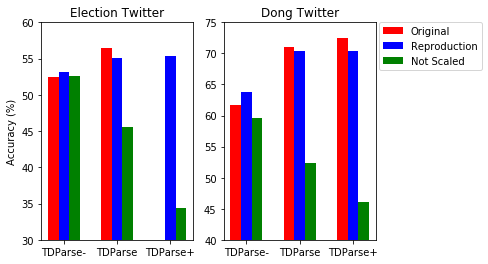

In [20]:
# Here we are graphing the affect of scaling and not scaling compared 
# to the original results

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  

index_model = {index : model for index, model in enumerate(models.keys())}
num_models = len(index_model)

# Plotting the Dong Twitter results
scaled_values = {result[1] : result[2] * 100 for result in dong_results if result[0] == 'Scaled'}
ordered_scaled_values = [scaled_values[index_model[index]] for index in range(num_models)]
original_values = {result[1] : result[2] for result in dong_results if result[0] == 'Original'}
ordered_original_values = [original_values[index_model[index]] for index in range(num_models)]
ns_values = {result[1] : result[2] * 100 for result in dong_results if result[0] == 'Not Scaled'}
ordered_ns_values = [ns_values[index_model[index]] for index in range(num_models)]

ind = np.arange(num_models)
width = 0.2
ax = plt.subplot(1, 2, 2)
original_bar = ax.bar(ind, ordered_original_values, width, color='r')
scaled_bar = ax.bar(ind + width, ordered_scaled_values, width, color='b')
ns_bar = ax.bar(ind + (2 * width), ordered_ns_values, width, color='g')

ax.set_xticks(ind + width)
ax.set_ylim([40 ,75])
model_names = [index_model[index] for index in range(num_models)]
ax.set_xticklabels(model_names)
ax.set_title('Dong Twitter')
leg = ax.legend((original_bar[0], scaled_bar[0], ns_bar), ('Original', 'Reproduction', 'Not Scaled'),
                loc = (1.02,0.78))

# Plotting the election results
scaled_values = {result[1] : result[2] * 100 for result in election_results if result[0] == 'Scaled'}
ordered_scaled_values = [scaled_values[index_model[index]] for index in range(num_models)]
original_values = {result[1] : result[2] for result in election_results if result[0] == 'Original'}
ordered_original_values = [original_values[index_model[index]] for index in range(num_models)]
ns_values = {result[1] : result[2] * 100 for result in election_results if result[0] == 'Not Scaled'}
ordered_ns_values = [ns_values[index_model[index]] for index in range(num_models)]

ax = plt.subplot(1, 2, 1)
original_bar = ax.bar(ind, ordered_original_values, width, color='r')
scaled_bar = ax.bar(ind + width, ordered_scaled_values, width, color='b')
ns_bar = ax.bar(ind + (2 * width), ordered_ns_values, width, color='g')

ax.set_xticks(ind + width)
ax.set_ylim([30 ,60])
model_names = [index_model[index] for index in range(num_models)]
ax.set_xticklabels(model_names)
ax.set_title('Election Twitter')
ax.set_ylabel('Accuracy (%)')
plt.show()

As we can see above the effect of not scaling is quite a lot and more so for the models that contain more parameters e.g. TDParse+. This again 

As you can see not scaling the data (in this can we used [MinMax](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) scaling) affects the results quite a lot more so for the models that contain more parameters e.g. TDParse+. This was not stated in the paper. They did use a different Support Vector Machine Library [LibLinear](https://www.csie.ntu.edu.tw/~cjlin/liblinear/) however we actually use this library just using the [Scikit-learn interface](http://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html). Even though in the [Practical guide to LibLinear](https://www.csie.ntu.edu.tw/~cjlin/papers/guide/guide.pdf) it states that you should scale and shows the importance like we have done above but this is not stated or reiterated in the paper.

This scaling effect can also be seen in the Target Dependent models of which that notebook can be found [here](./target_model.ipynb)

## Lastly the affect of a different parser

Currently we have been using a type specific parser *Tweebo* however we shall now see the difference this makes compared to using a non type specific parser *stanford* specifically we are using **Stanford CoreNLP 3.7** and the [Neural Network Dependency parser](https://nlp.stanford.edu/software/nndep.shtml).

Below we find the best C value while using the Stanford Dependency parser and then compare results on the test set compared to the Tweebo results that we have shown earlier.

In [34]:
# Find the best C value and store the result for the Dong Twitter dataset
model_stanford_results_path = {'TDParse-' : add_folder('TDParse- stanford C.json'),
                               'TDParse' : add_folder('TDParse stanford C.json'),
                               'TDParse+' : add_folder('TDParse+ stanford C.json')}
model_c_value_dong_stanford = {}

for model_name, model in models.items():
    parameters = {**model_parameters[model_name]}
    parameters['parser'] = stanford
    stanford_result_path = model_stanford_results_path[model_name]
    model_c_value_dong_stanford[model_name] = dataset_best_c(dong_train, model, result_path=stanford_result_path,
                                                             dataset_name='Dong Twitter', **parameters)

The best C values for stanford on the Dong Twitter dataset for **TDParse-** is {{model_c_value_dong_stanford['TDParse-'][0]}} for **TDParse** is {{model_c_value_dong_stanford['TDParse'][0]}} and for **TDParse+** is {{model_c_value_dong_stanford['TDParse+'][0]}}

In [35]:
# Find the best C value and store the result for the Election Twitter dataset
model_c_value_elections_stanford = {}

for model_name, model in models.items():
    parameters = {**model_parameters[model_name]}
    parameters['parser'] = stanford
    stanford_result_path = model_stanford_results_path[model_name]
    model_c_value_elections_stanford[model_name] = dataset_best_c(election_train, model, 
                                                                  result_path=stanford_result_path,
                                                                  dataset_name='Election Twitter', **parameters)

The best C values for stanford on the Election Twitter dataset for **TDParse-** is {{model_c_value_elections_stanford['TDParse-'][0]}} for **TDParse** is {{model_c_value_elections_stanford['TDParse'][0]}} and for **TDParse+** is {{model_c_value_elections_stanford['TDParse+'][0]}}

In [36]:
# Using the best C value train on the whole training set and predict on the test for
# both datasets
def scores_dataset(model, model_name, parameters, train, test, dataset_name):
    model.fit(train.data(), train.sentiment_data(), params=parameters)
    predictions = model.predict(test.data())
    acc_score = model.score(test.sentiment_data(), predictions, accuracy_score)
    return dataset_name, model_name, acc_score


score_dataset_stanford_params = []
for dataset_name, dataset in datasets.items():
    train, test = dataset
    for model_name, model in models.items():
        parameters = {**model_parameters[model_name]}
        parameters['parser'] = stanford
        if dataset_name == 'Dong Twitter':
            parameters['C'] = model_c_value_dong_stanford[model_name][0]
        else:
            parameters['C'] = model_c_value_elections_stanford[model_name][0]
        
        parameters = model.get_params(**parameters)
        score_dataset_stanford_params.append((model, model_name, parameters, 
                                              train, test, dataset_name))
with Pool(6) as pool:
    model_results = pool.starmap(scores_dataset, score_dataset_params)

Below we compare the Stanford to the Tweebo parser after processing all of the Stanford results directly above

In [38]:
dong_stanford = {result[1] : result[2] for result in model_results if result[0] == 'Dong Twitter'}
election_stanford = {result[1] : result[2] for result in model_results if result[0] == 'Election Twitter'}
dong_tweebo = {result[1] : result[2] for result in dong_results if result[0] == 'Scaled'}
election_tweebo = {result[1] : result[2] for result in election_results if result[0] == 'Scaled'}

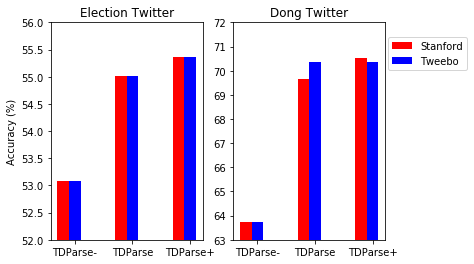

In [50]:
# Plot for Dong twitter data
index_model = {index : model for index, model in enumerate(dong_stanford.keys())}
num_models = len(index_model)

# Plotting the Dong Twitter results
dong_stanford_values = [dong_stanford[index_model[index]] * 100 for index in range(num_models)]
dong_tweebo_values = [dong_tweebo[index_model[index]] * 100 for index in range(num_models)]

ind = np.arange(num_models)
width = 0.2
ax = plt.subplot(1, 2, 2)
dong_stanford_bar = ax.bar(ind, dong_stanford_values, width, color='r')
dong_tweebo_bar = ax.bar(ind + width, dong_tweebo_values, width, color='b')

ax.set_xticks(ind + width)
ax.set_ylim([63 ,72])
model_names = [index_model[index] for index in range(num_models)]
ax.set_xticklabels(model_names)
ax.set_title('Dong Twitter')
leg = ax.legend((dong_stanford_bar[0], dong_tweebo_bar[0]), ('Stanford', 'Tweebo'),
                loc = (1.02,0.78))

# Plot for Elections Twitter data
elections_stanford_values = [election_stanford[index_model[index]] * 100 for index in range(num_models)]
elections_tweebo_values = [election_tweebo[index_model[index]] * 100 for index in range(num_models)]

ax = plt.subplot(1, 2, 1)
election_stanford_bar = ax.bar(ind, elections_stanford_values, width, color='r')
election_tweebo_bar = ax.bar(ind + width, elections_tweebo_values, width, color='b')

ax.set_xticks(ind + width)
ax.set_ylim([52 ,56])
model_names = [index_model[index] for index in range(num_models)]
ax.set_xticklabels(model_names)
ax.set_title('Election Twitter')
ax.set_ylabel('Accuracy (%)')
plt.show()

As we can see above there is no difference between the parsers for the Elections dataset and some differences in the Dong dataset. Thus showing that a domain specific dependency parser does not make much difference in this case.